In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, top_k_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import    

In [2]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index), uniques.tolist()

In [3]:
labels_with_few_samples = ['web_attack', 'exploit_source']

In [4]:
df = pd.read_csv("base_features.csv")
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

In [5]:
df['label'], labels = column_adjustor(df['label'])
{i: label for i, label in enumerate(labels)}

{0: 'phishing',
 1: 'malware_hosting',
 2: 'command_and_control',
 3: 'exploit_kit',
 4: 'scanning_host',
 5: 'malvertising',
 6: 'cc_skimming',
 7: 'spam',
 8: 'good'}

In [6]:
df['label'].value_counts()

label
8    235721
0     73345
2     66490
7     46009
1     16726
5      3085
4       231
3        82
6        12
Name: count, dtype: int64

In [7]:
class_weights = compute_class_weight(class_weight="balanced", classes = np.unique(df['label']), y=df['label'])
class_weights

array([6.69137486e-01, 2.93422748e+00, 7.38124363e-01, 5.98510840e+02,
       2.12458393e+02, 1.59085539e+01, 4.08982407e+03, 1.06670193e+00,
       2.08203295e-01])

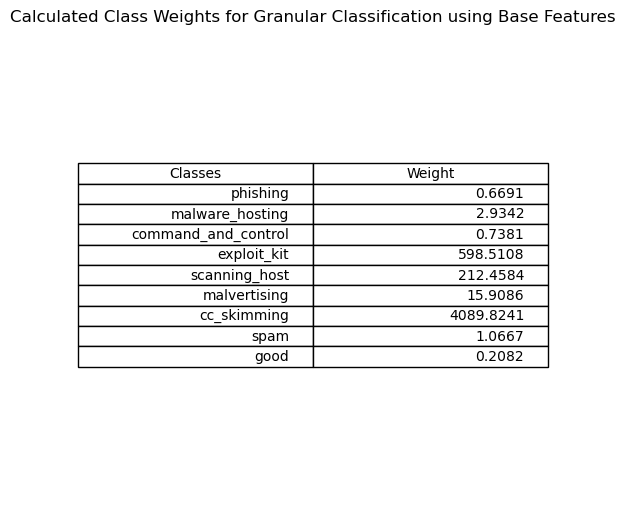

In [8]:
class_weights_df = pd.DataFrame({"Classes": labels, "Weight": class_weights.round(4)})
class_weights_df 

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = class_weights_df .values, colLabels = class_weights_df .columns, loc="center")
plt.tight_layout()
plt.title(f"Calculated Class Weights for Granular Classification using Base Features")
plt.show()
plt.close(fig)

In [9]:
all_accuracy_scores = {}
all_confusion_matrices = {}

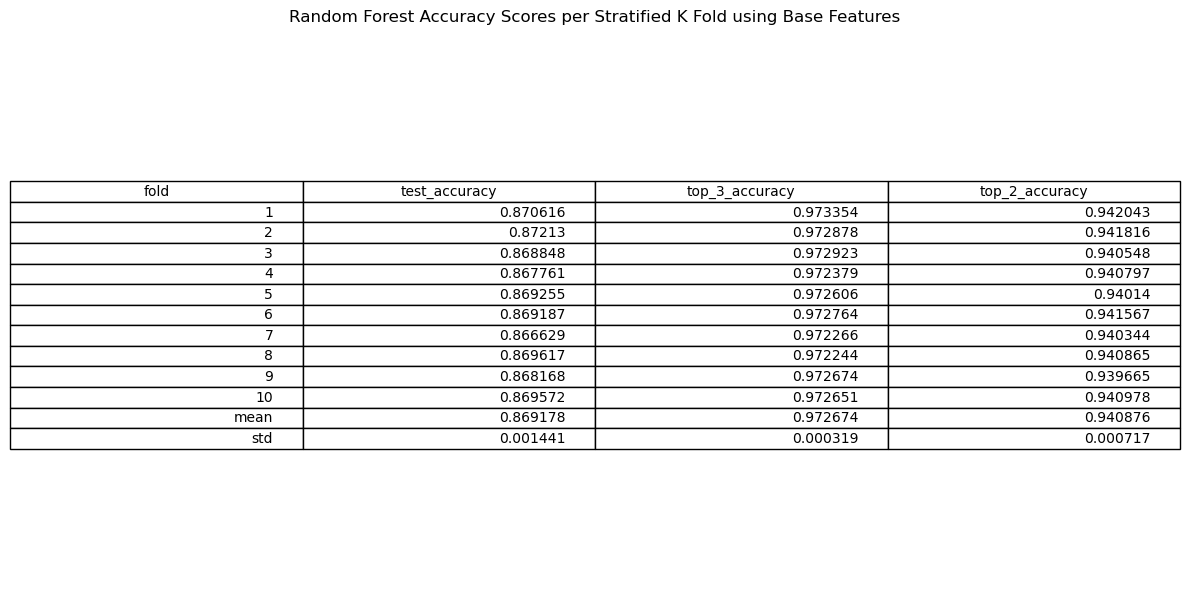

In [10]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

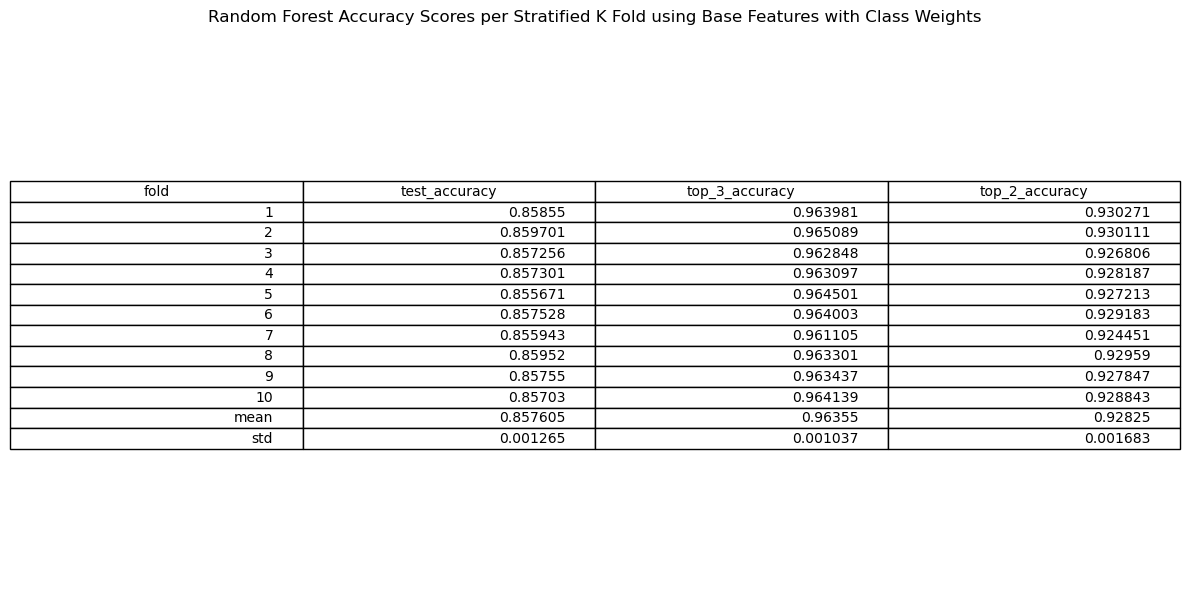

In [11]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight="balanced")

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using Base Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

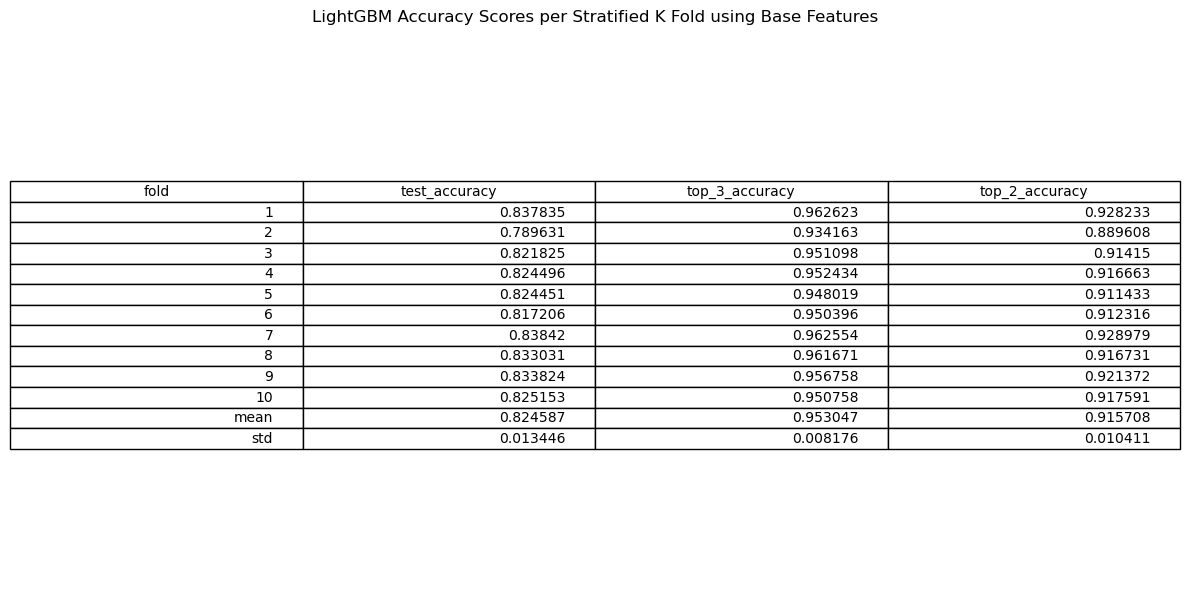

In [12]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

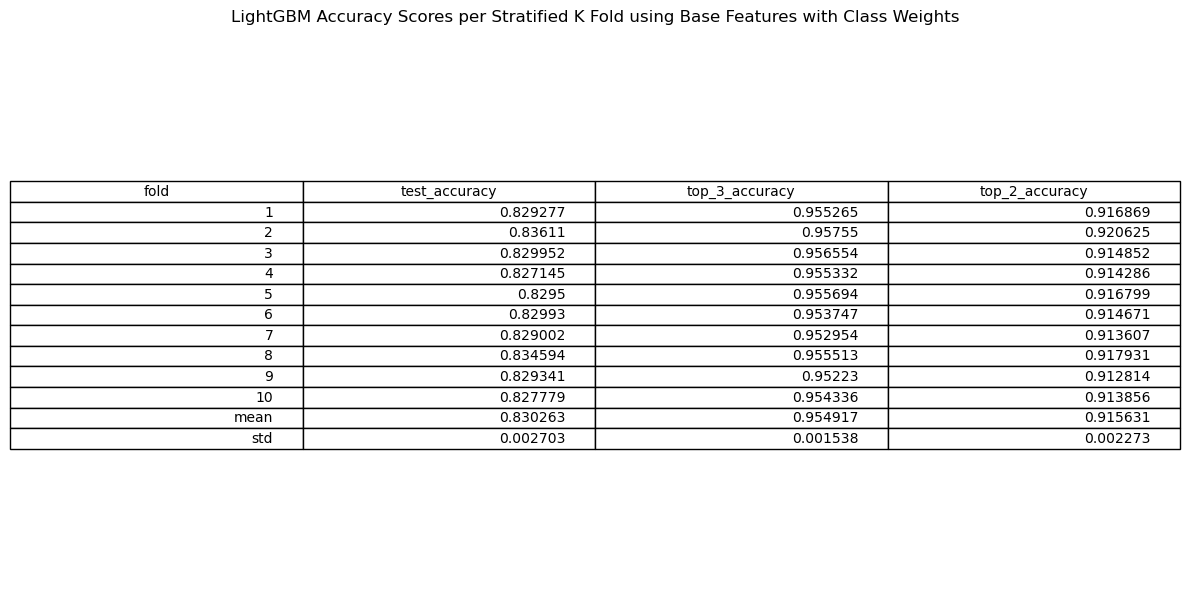

In [13]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight={i: v for i, v in enumerate(list(class_weights))})

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using Base Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

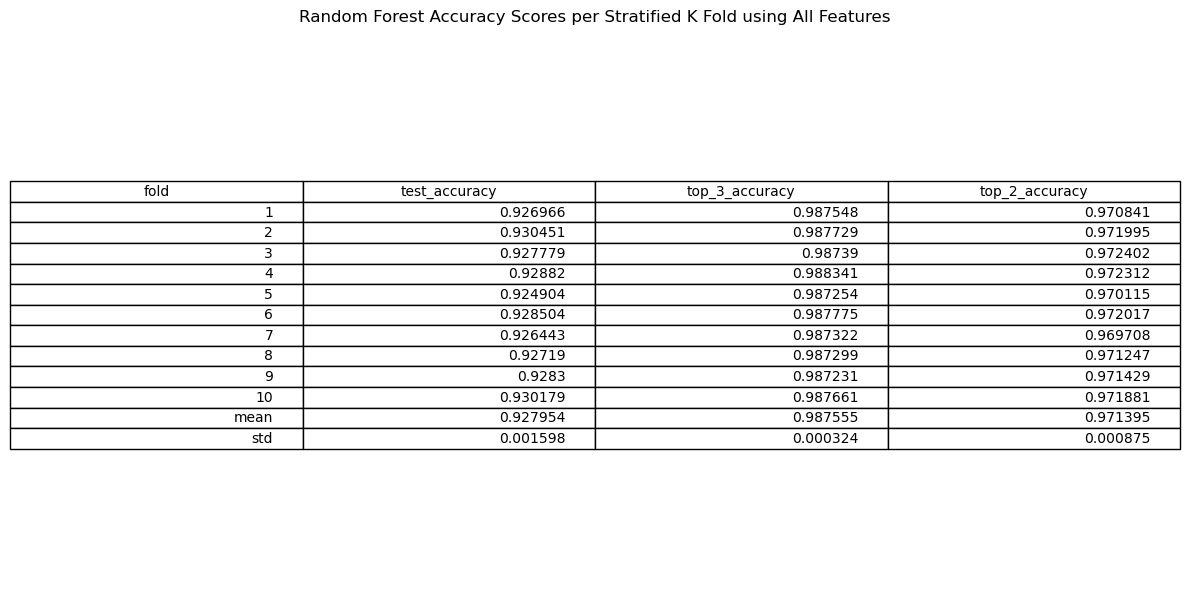

In [18]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

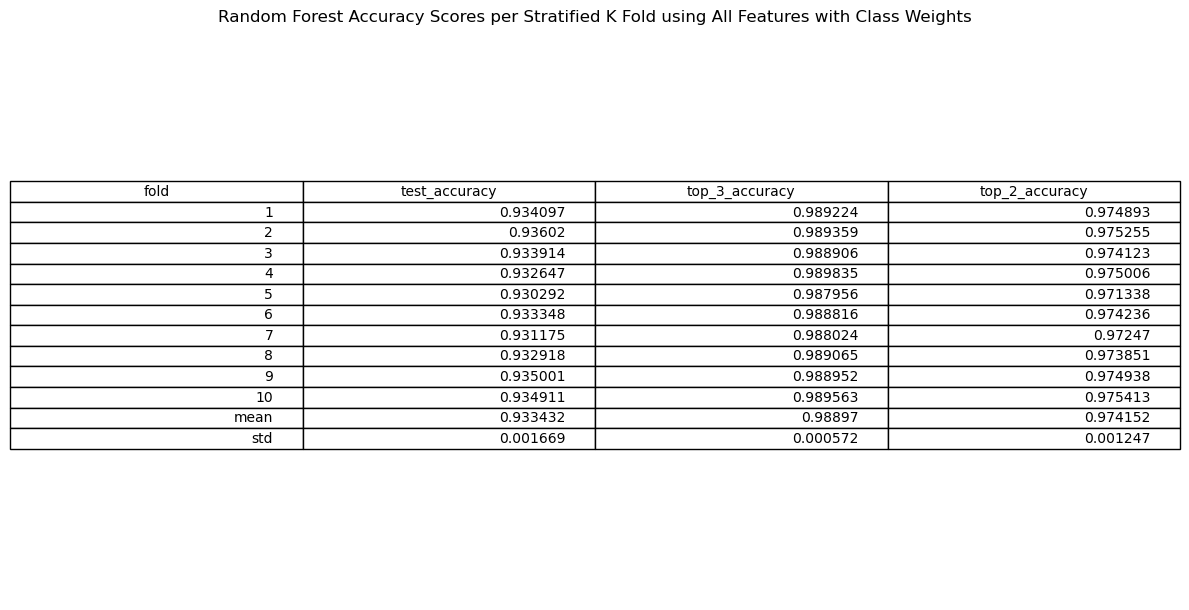

In [19]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight="balanced")

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using All Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

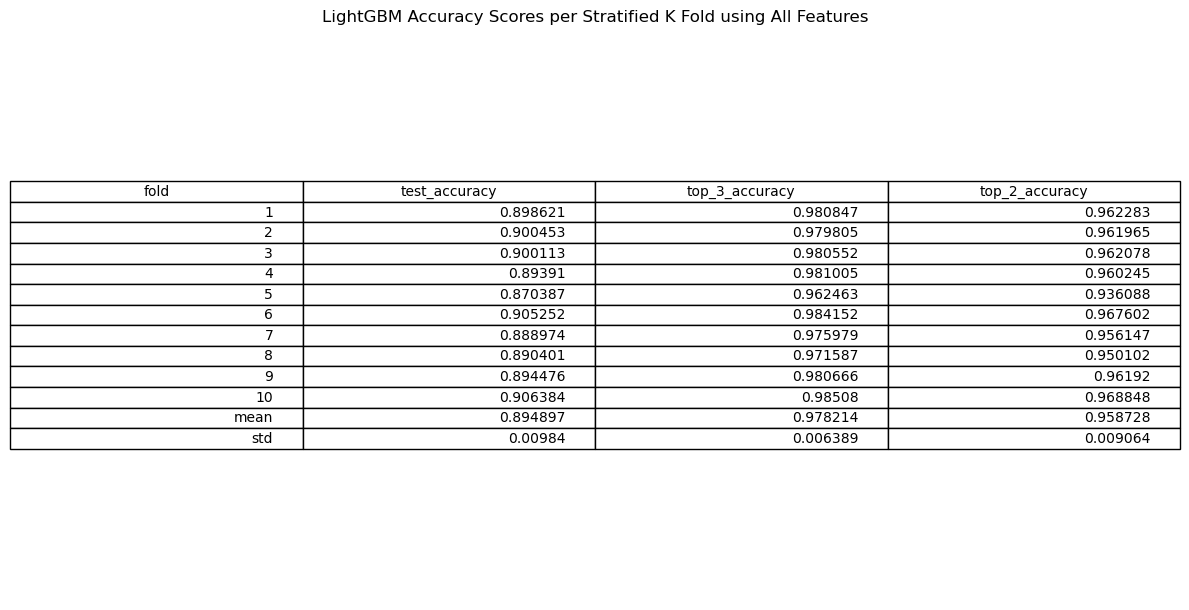

In [20]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

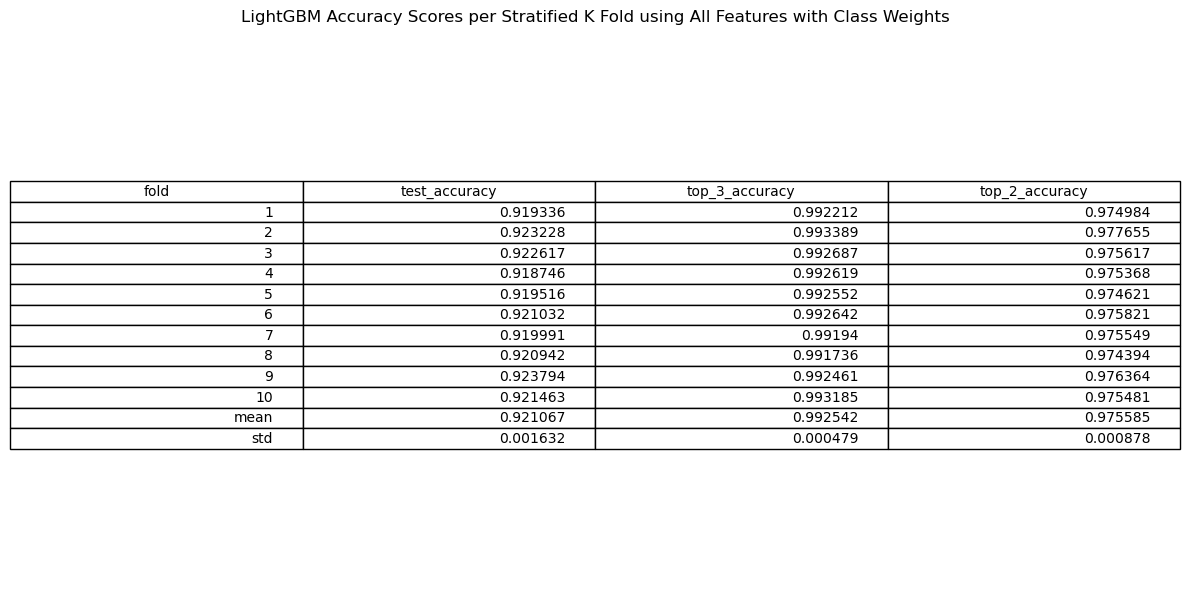

In [21]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight={i: v for i, v in enumerate(list(class_weights))})

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using All Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

In [ ]:
df = pd.read_csv("base_features.csv")
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
malvertising             3085
scanning_host             231
exploit_kit                82
cc_skimming                12
exploit_source              4
web_attack                  2
Name: count, dtype: int64

In [ ]:
labels_with_few_samples = ['web_attack', 'exploit_source', 'exploit_kit', 'cc_skimming', 'scanning_host', 'malvertising']

In [ ]:
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)
df['label'].value_counts()

label
good                   235721
phishing                73345
command_and_control     66490
spam                    46009
malware_hosting         16726
Name: count, dtype: int64

In [ ]:
df['label'], labels = column_adjustor(df['label'])
{i: label for i, label in enumerate(labels)}

{0: 'phishing',
 1: 'malware_hosting',
 2: 'command_and_control',
 3: 'spam',
 4: 'good'}

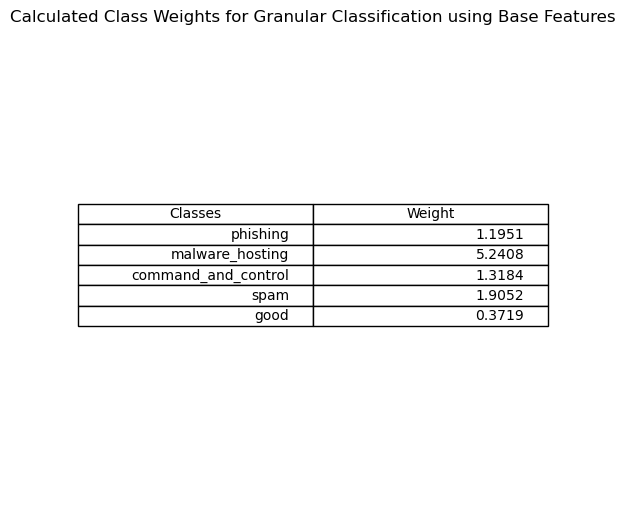

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes = np.unique(df['label']), y=df['label'])
class_weights_df = pd.DataFrame({"Classes": labels, "Weight": class_weights.round(4)})
class_weights_df 

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = class_weights_df .values, colLabels = class_weights_df .columns, loc="center")
plt.tight_layout()
plt.title(f"Calculated Class Weights for Granular Classification using Base Features")
plt.show()
plt.close(fig)

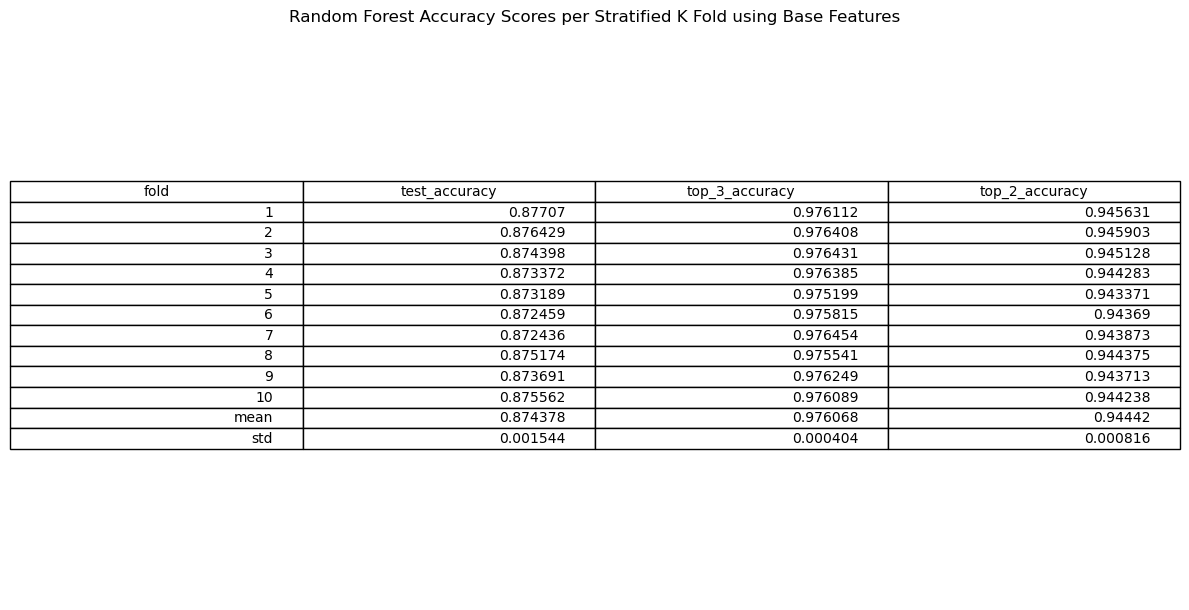

In [ ]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

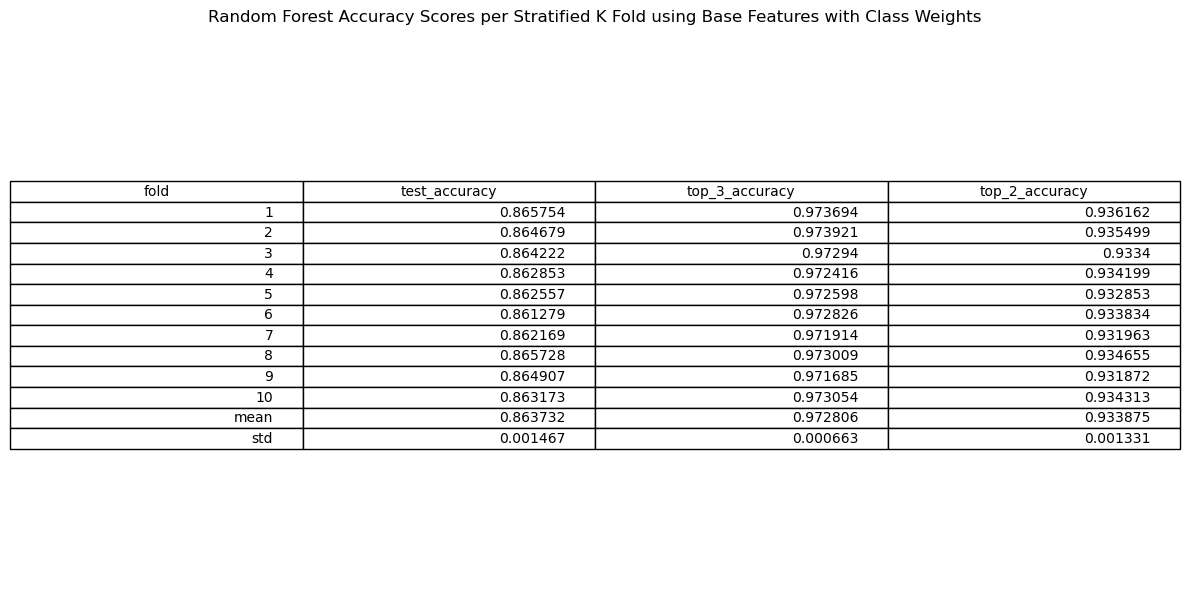

In [ ]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight="balanced")

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using Base Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

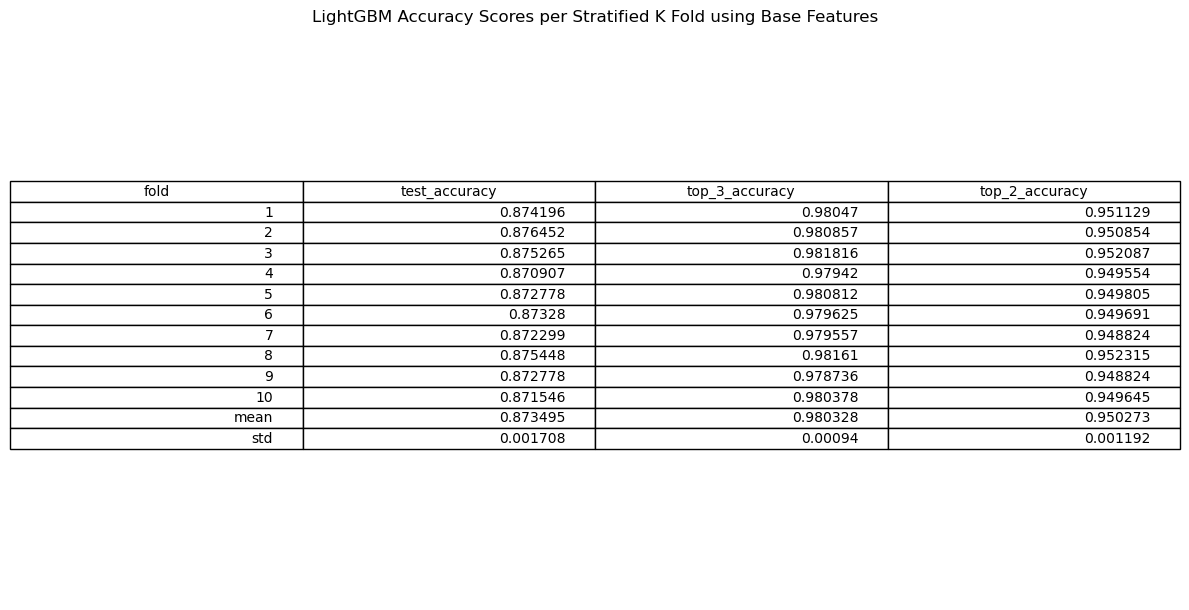

In [ ]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

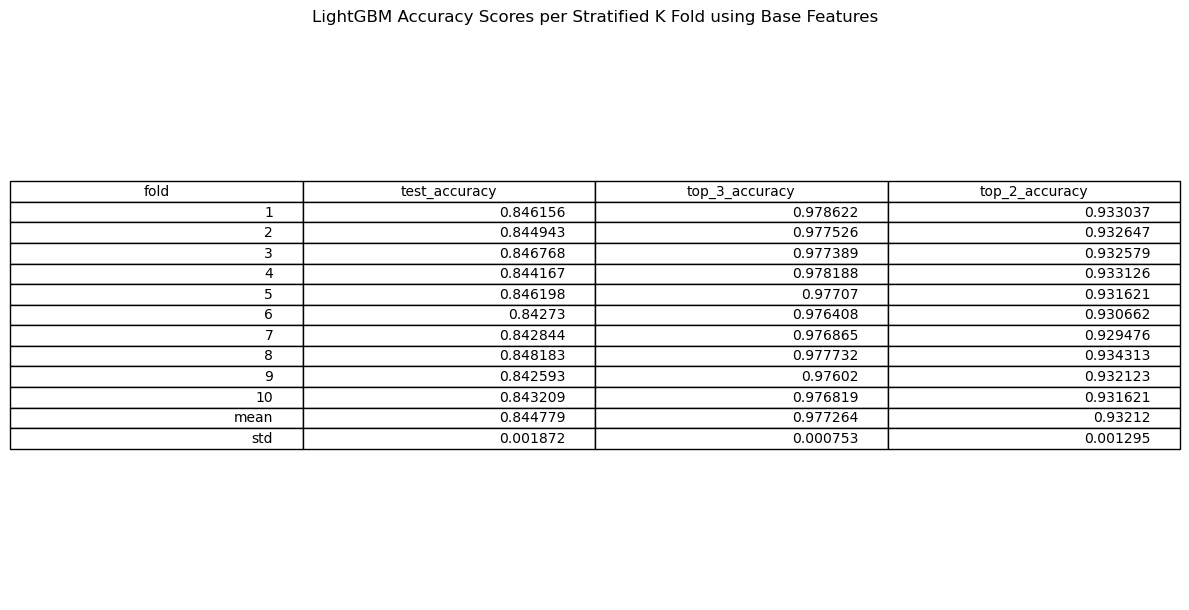

In [ ]:
FEATURE_GROUP = "base_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight="balanced")

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using Base Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

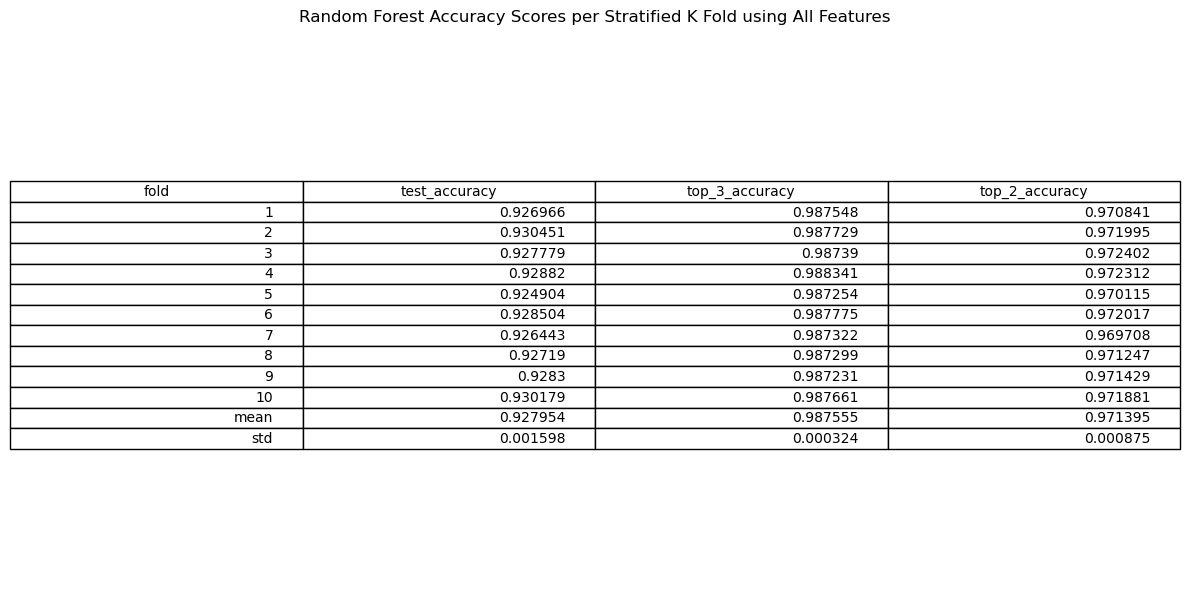

In [22]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

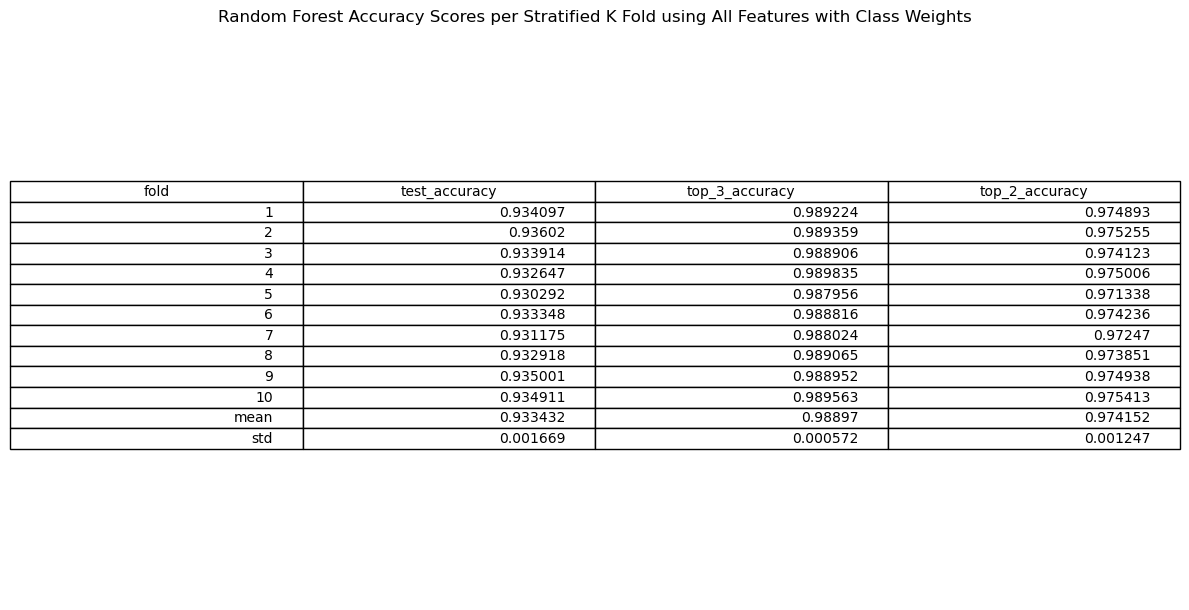

In [23]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight="balanced")

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = rf.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"Random Forest Accuracy Scores per Stratified K Fold using All Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

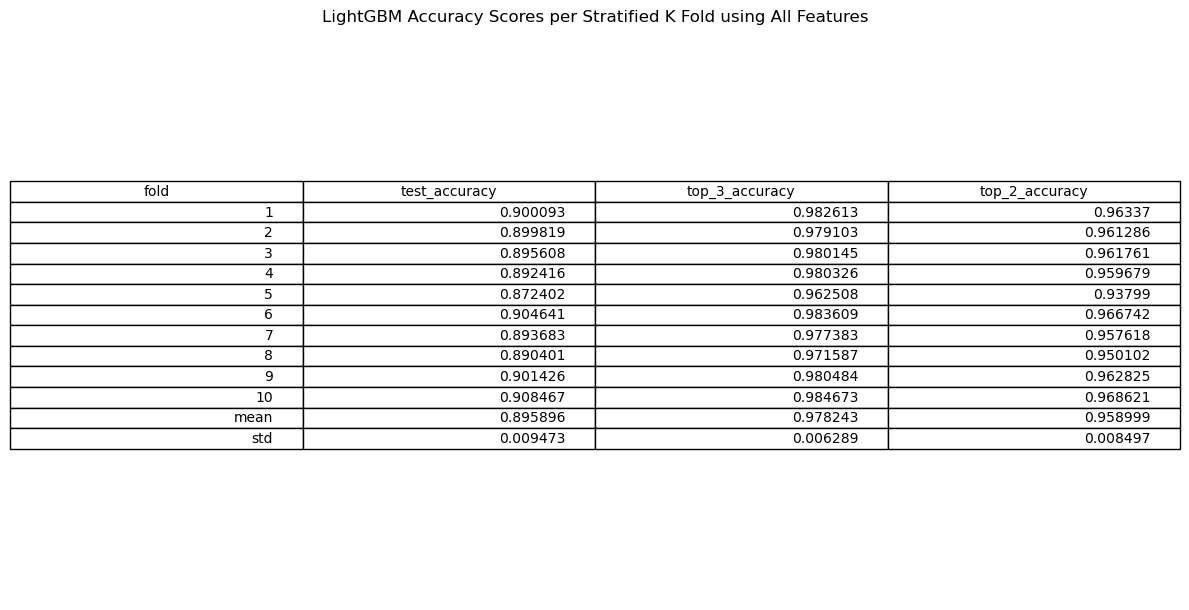

In [24]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using All Features")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores

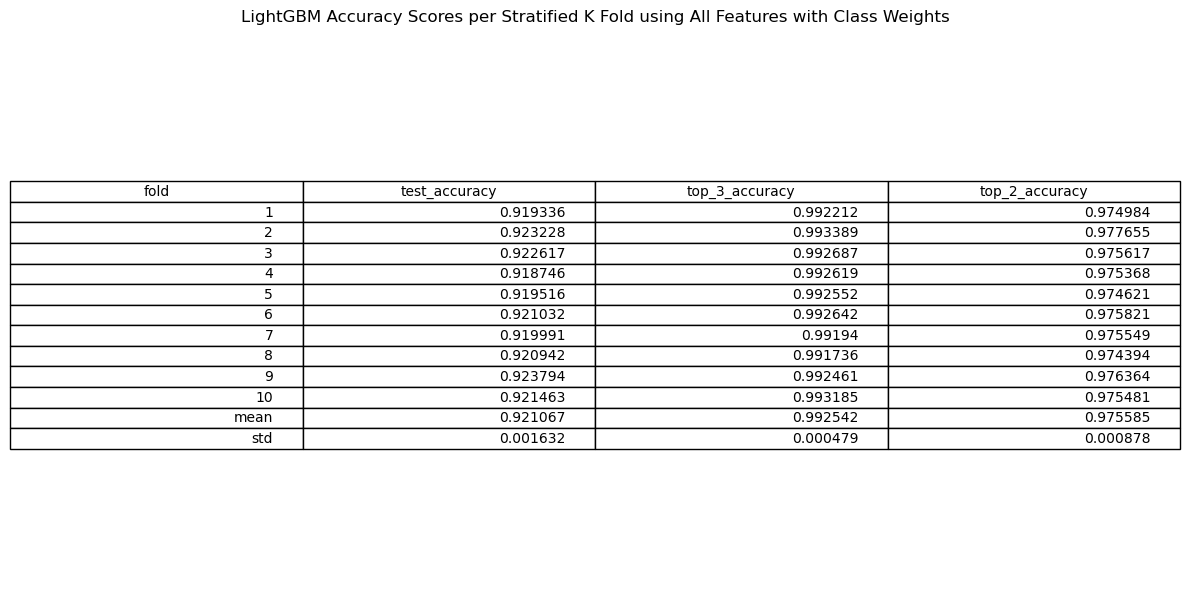

In [25]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features=None, class_weight={i: v for i, v in enumerate(list(class_weights))})

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}
# X_tests = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    # all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    y_pred_proba = lgbm.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_df = pd.DataFrame(scoring_metrics)

mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_df[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"LightGBM Accuracy Scores per Stratified K Fold using All Features with Class Weights")
plt.show()
plt.close(fig)

# all_accuracy_scores[k] = scores